# ROC_all

Generate receiver operating curves for ALL CNNs, PFNs, and BDTs.

Outputs are stored in `<data_dir>/model_outputs/<task_name>_pfn_test.npz`. Keys are `raw_outputs` and `y_true`.

In [6]:
import sys
sys.path.append("..")

from utils import data_dir

import numpy as np
from scipy.special import softmax

import matplotlib.pyplot as plt

In [8]:
task_name = "scalar1"

In [122]:
def compute_ROC(raw_outputs, y_true):
    """
    Inputs:
        - raw_outputs is an N x 3 array of final model outputs.
        - y_true is a list of ints with classes.
    Returns:
        - a list of coordinates (sig_eff, 1/bkg_eff) to comprise a curve.
        - a list of (sig_eff, 1/bkg_eff) for given working poitns.
    """
    raw_probs = softmax(raw_outputs, axis=1)
    sig_probs = raw_probs[y_true == 2][:,2]
    bkg_probs = raw_probs[y_true < 2][:,2]

    # def get_eff(probs, work_points):
    #     # Compute efficiency for given working points
    #     if isinstance(work_points, float):
    #         work_points = np.array([work_points])
        
    #     N = len(probs)
    #     probs_ = np.broadcast_to(probs, (N, len(work_points)))
    
    def get_thresh(working_point, atol=1e-6):
        # Get threshold given working point using *binary search*!
        # Recall: working point is desired signal efficiency.
        lo = 0
        hi = 1
        while hi - lo > atol:
            mid = (lo + hi) / 2
            if np.mean(sig_probs > mid) > working_point:
                lo = mid
            else:
                hi = mid
        return (lo + hi) / 2

    working_points = np.linspace(0.95, 1, 100)
    table = []
    for wp in working_points:
        thresh = get_thresh(wp)
        table.append((np.mean(sig_probs > thresh), np.mean(bkg_probs > thresh)))

    return np.array(table)

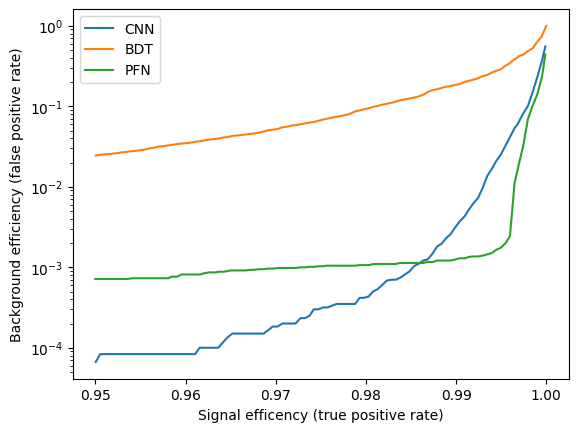

In [123]:
plt.yscale("log")
plt.xlabel("Signal efficency (true positive rate)")
plt.ylabel("Background efficiency (false positive rate)")

for model in ["cnn", "bdt", "pfn"]:
    outputs = np.load(f"{data_dir}/model_outputs/{task_name}_{model}_test.npz")
    raw_outputs = outputs["raw_outputs"]
    y_true = outputs["y_true"]

    table = compute_ROC(raw_outputs, y_true)
    plt.plot(*table.T, label=model.upper())

plt.legend()